## Import required libaries

In [3]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

2023-02-18 15:50:41.962794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Input the data

In [5]:
directory = "Data/Medical mask/Medical mask/Medical Mask/annotations"
image_set = "Data/Medical mask/Medical mask/Medical Mask/images"
df_train = pd.read_csv("Data//train.csv")
df_test = pd.read_csv("Data/submission.csv")

In [6]:
cvNet = cv2.dnn.readNetFromCaffe('CaffeFaceDetector/architecture.txt','CaffeFaceDetector/weights.caffemodel')

### Functions

JSON Function fetches the json file that has the data of bounding box in the training dataset.

In [7]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

Gamma is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems. 
In simple terms it is used to instill some light in the image. 
Image will shift towards darker end of the spectrum when gamma < 1, and if gamma > 1, there will be more light in the image.

In [8]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

## Prepare the data

In [9]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '5045.jpg',
 'NumOfAnno': 4,
 'Annotations': [{'isProtected': False,
   'ID': 516598418402004352,
   'BoundingBox': [1737, 339, 2062, 740],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 131128420050989904,
   'BoundingBox': [636, 207, 946, 634],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 944789222496780416,
   'BoundingBox': [677, 399, 929, 620],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 587553649932228096,
   'BoundingBox': [1812, 516, 2049, 722],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}}]}

In [10]:
df_train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


We extract the bounding box data from json by the mask and non_mask label. The faces from any particular image are extracted and stored in the data list along with its label for the training process.

In [11]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df_train["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_set,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_set,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

<AxesSubplot:ylabel='count'>

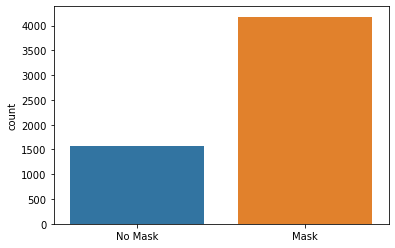

In [12]:
p = []
for d in data:
    if(d[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

We see that there are more mask compared with no mask data. However, this imbalance would not matter a lot, by using a SSD pretrained model, which is trained to detect non-mask faces.

In [13]:
X = []
y = []
for features,label in data:
    X.append(features)
    y.append(label)

In [14]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
y = np.array(y)

## Modeling and Training

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2023-02-18 15:53:06.877709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [19]:
X_train,X_validate,y_train,y_validate = train_test_split(X, y,train_size=0.8,random_state=0)

### Training Generator

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(X_train)

### Modeling

In [21]:
steps = X_train.shape[0]//32
epochs = 20

In [22]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=steps,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_validate, y_validate))

Epoch 1/20
143/143 [==============================] - 849s 6s/step - loss: 0.4988 - accuracy: 0.7624 - val_loss: 0.2840 - val_accuracy: 0.9043
Epoch 2/20
143/143 [==============================] - 822s 6s/step - loss: 0.3495 - accuracy: 0.8340 - val_loss: 0.2474 - val_accuracy: 0.9139
Epoch 3/20
143/143 [==============================] - 798s 6s/step - loss: 0.3084 - accuracy: 0.8592 - val_loss: 0.2176 - val_accuracy: 0.9113
Epoch 4/20
143/143 [==============================] - 653s 5s/step - loss: 0.2986 - accuracy: 0.8653 - val_loss: 0.2232 - val_accuracy: 0.9113
Epoch 5/20
143/143 [==============================] - 428s 3s/step - loss: 0.3007 - accuracy: 0.8754 - val_loss: 0.1948 - val_accuracy: 0.9157
Epoch 6/20
143/143 [==============================] - 408s 3s/step - loss: 0.2902 - accuracy: 0.8732 - val_loss: 0.2343 - val_accuracy: 0.9096
Epoch 7/20
143/143 [==============================] - 431s 3s/step - loss: 0.2891 - accuracy: 0.8800 - val_loss: 0.2297 - val_accuracy: 0.9009

In [23]:
model.save_weights('mask_detection_model.h5')

### Training and Validation Visualization

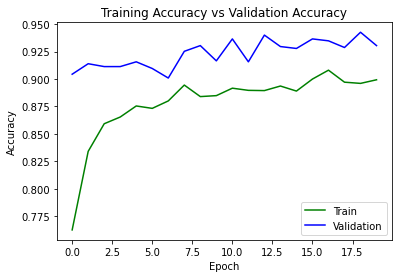

In [39]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('accuracy.png')

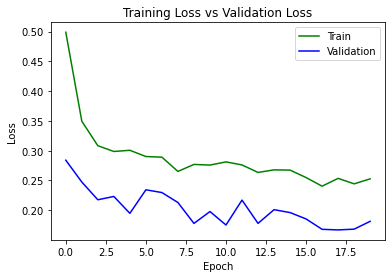

In [40]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('loss.png')

### Test our model

We randomly pick 6 test images from our test dataset:

In [36]:
import os
import random

folder_path = 'Data/mask/Medical Mask/images'
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".png")]

# Randomly select 6 image files from the list
random_images = random.sample(image_files, 6)    

['Data/mask/Medical Mask/images/5598.jpg', 'Data/mask/Medical Mask/images/4970.jpg', 'Data/mask/Medical Mask/images/1259.jpg', 'Data/mask/Medical Mask/images/0725.jpg', 'Data/mask/Medical Mask/images/0711.jpg', 'Data/mask/Medical Mask/images/1983.jpg']


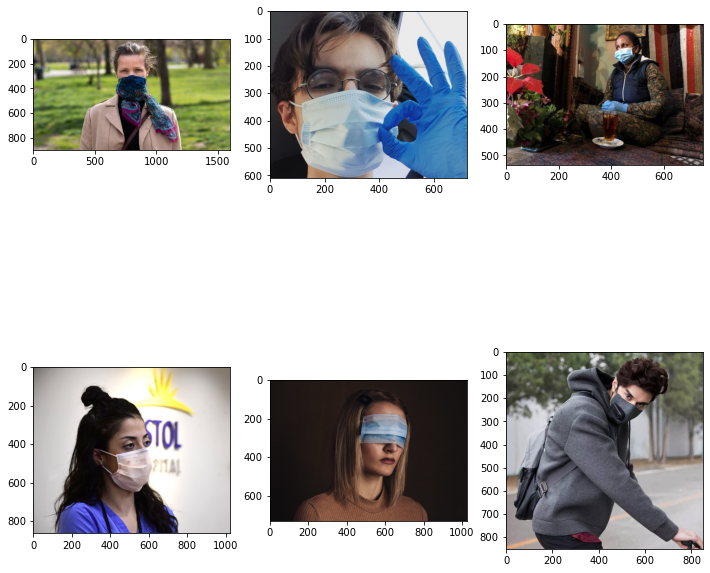

<Figure size 432x288 with 0 Axes>

In [47]:
# Print the list of randomly selected image files
plt.figure(figsize=(12,12))
for i in range(0,6):
    plt.subplot(2,3,i+1)
    img = random_images[i]
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.savefig('sample.png')

1/1 [==============================] - 0s 76ms/step


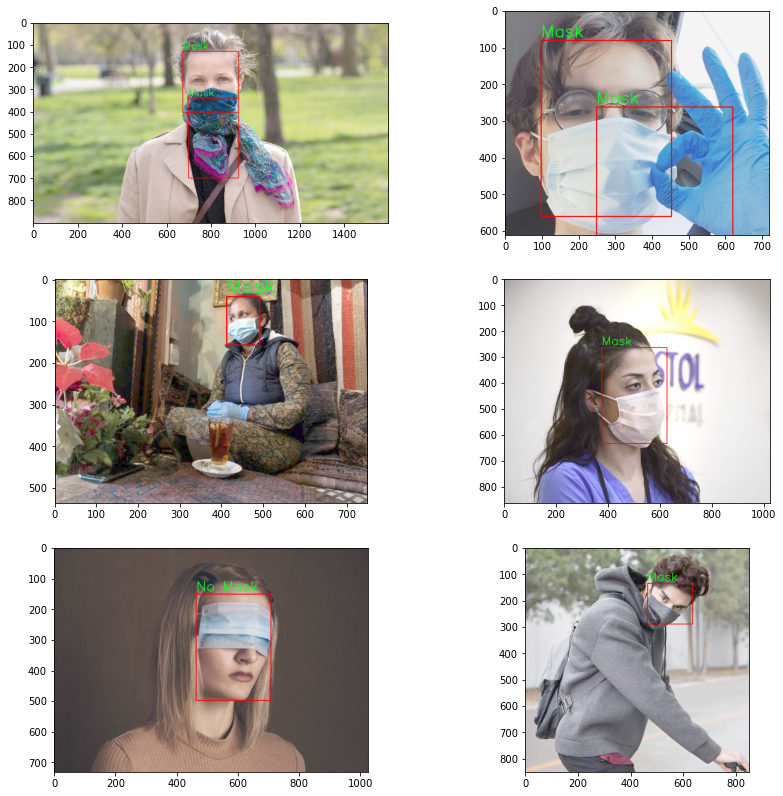

<Figure size 432x288 with 0 Axes>

In [38]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for i,img in enumerate(random_images):
    image =  adjust_gamma(cv2.imread(img,1), gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                img = cv2.resize(frame,(img_size,img_size))
                img = np.array(im)/255.0
                img = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, i+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
plt.savefig('mask_detected.png')